# Creating a NeuralNetwork from scratch
> A tutorial to code a neural network from scratch in python using numpy.

- toc: false
- badges: true
- comments: true
- categories: [deeplearning python3.x numpy]
- image: images/backprop.jpeg

I will assume that you all know what a artificial neural network is and have a little bit of knowledge about `forward and backward propagation`. Just having a simple idea is enough.

If you do not know what the above terms are or would like to brush up on the topics , I would suggest this amazing [youtube playlist by 3Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi).

> youtube: https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

## Setting up Imports:

In [35]:
import numpy as np
import gzip
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import warnings


np.random.seed(123)
%matplotlib inline
warnings.filterwarnings("ignore")

## Preparing the data

For this blog post, we'll use one of the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database). MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

Run the code below to download the `MNIST` dataset. The dataset will be downloaded to the path `../../Datasets/` or you can modify the path as you like.

In [ ]:
!wget -P "../../Datasets/" http://deeplearning.net/data/mnist/mnist.pkl.gz

In [2]:
def get_data(path):
    """
    Fn to unzip the MNIST data and return
    the data as numpy arrays
    """
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(np.array, (x_train,y_train,x_valid,y_valid))

In [58]:
x_train,y_train,x_valid,y_valid = get_data(path= "../../Datasets/mnist.pkl.gz")

In [59]:
tots,feats = x_train.shape
print("Shape of x_train:",x_train.shape)
print("Total number of examples:", tots)
print("Number of pixel values per image:", feats)

Shape of x_train: (50000, 784)
Total number of examples: 50000
Number of pixel values per image: 784


To make our life a bit easier we are going to take only the examples that contain a 1 or 0.

In [60]:
zero_mask = [y_train==0] # grab all the index values where 0 is present
one_mask = [y_train==1] # grad all the index valus where 1 is present

# grab all the 1's and 0's and make training set
x_train = np.vstack((x_train[zero_mask], x_train[one_mask]))
y_train = np.reshape(y_train, (-1,1))
y_train = np.squeeze(np.vstack((y_train[zero_mask], y_train[one_mask])))

In [61]:
x_train.shape, y_train.shape

((10610, 784), (10610,))

Hence, now our training set has 10610 examples

In [64]:
# similarly let's convert out validation set
zero_mask = [y_valid==0] # grab all the index values where 0 is present
one_mask = [y_valid==1] # grad all the index valus where 1 is present

# grab all the 1's and 0's and make training set
x_valid = np.vstack((x_valid[zero_mask], x_valid[one_mask]))
y_valid = np.reshape(y_valid, (-1,1))
y_valid = np.squeeze(np.vstack((y_valid[zero_mask], y_valid[one_mask])))

In [65]:
x_valid.shape, y_valid.shape

((2055, 784), (2055,))

Hence, now our training set has 2055 examples

Let's view one image from our dataset:

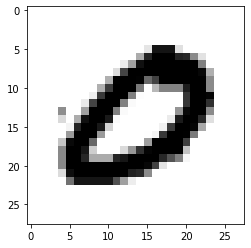

In [69]:
plt.imshow(x_train[50].reshape(28,28), cmap="binary");

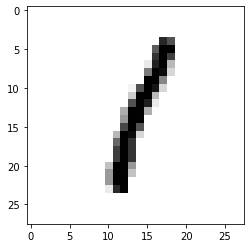

In [74]:
plt.imshow(x_train[5000].reshape(28,28), cmap="binary");

## Basic Model Architecture

For this task we are going to use a very basic model architecture this 2 linear layers and a output layer with 10 outputs.

In [77]:
#hide_input
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

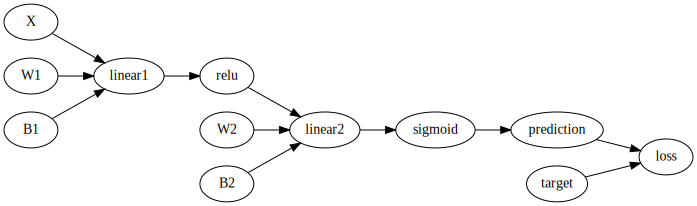

In [233]:
#hide_input
gv('''
X->linear1->relu->linear2->sigmoid->prediction->loss
W1->linear1
B1->linear1
W2->linear2
B2->linear2
target->loss
''')

## Let's take a deep dive into what this network means:

Let's take at look at all the individual components of this network:
- **Linear:**
  The linear layer computes the following :      
   ```
   out = matmul(input,W1) + B1
   ```
   
- **ReLU:** 
  The relu computes the following:
  ```
  out = max(0, input)
  ```
- **Sigmoid:** 
  The sigmoid computes the following:
  ```
  out = 1/(1 + e.pow(input))
  ```
  
- **Loss:** 
  For the loss we are going to use the CrossEntropy Loss which is defined by the follwoing equation:
  $$loss= -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(yhat^{(i)}\right) + (1-y^{(i)})\log\left(1-yhat^{(i)}\right)) $$

**Now that we have our model architecture, let's create the different parts needed to assemble the model:**
- linear layer
- relu activation
- sigmoid activation
- loss

The `Backward` pass of out model would look something like this:

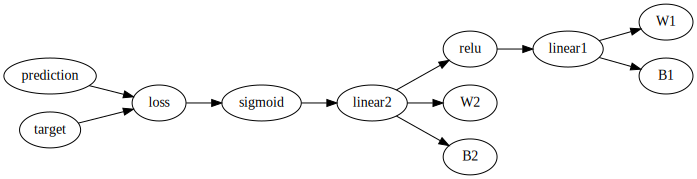

In [234]:
#hide_input
gv('''
prediction->loss
loss->sigmoid
sigmoid->linear2
linear2->relu
relu->linear1
linear2->W2
linear2->B2
linear1->W1
linear1->B1
target->loss
''')

**Let's first try to make some sense of what is happening in the backward and forward pass of our model:**

> **On paper our forward pass would look like this is pseudo-code**:
    
```python
inputs = x # original inputs
targets = y # original targets

z1 = inputs @ w2 + b2
a1 = relu(z1)

z2 = a1 @ w2 + b2
a2 = sigmoid(z2) # this is our model prediction

loss = loss_fn(a2, targets)
```

> **Consequently our backward pass in psuedo code would be something like this**:

```python

# let us assume that the `grad()` computes the gradeients of to given inputs

def grad(input1, input2):
    """
    computes the gradient of input1 wrt to input2
    """
    g = ... # the gradient of input1 wrt to input2, we will worry about this afterwards
    return g

# -------------------- #
# Backward Pass :
# --------------------- #

dL  = grad(loss, a2) # this is the gradient of the loss wrt output of the previous layer
da2 = grad(a2, z2) # this is the gradient of a2 wrt z2

# this is the gradient of the weights w2 wrt loss
# this is used to update the parameters
dw2 = grad(w2, loss)
dw2 = grad(loss, a2) * grad(a2, z2) * grad(z2, w2) # using chain rule
dw2 = dL * da2 * grad(z2, w2)
dw2 = grad_of_prev_layers * grad(z2, w2)

# this is the gradient of the bias b2 wrt loss
db2 = grad(b2, loss)
db2 = grad(loss, a2) * grad(a2, z2) * grad(z2, b2) # using chain rule
db2 = dL * da2 * grad(z2, b2)
db2 = grad_of_prev_layers * grad(z2, b2)


dz2 = grad(z2, a1) # this is the gradient of z2 wrt a1
da1 = grad(a1, z1) # this the gradient of a1 wrt to z1

# this is the gradient of the weights w1 wrt loss
dw1 = grad(w1, loss)
dw1 = grad(loss, a2) * grad(a2, z2) * grad(z2, a1) * grad(a1, z1) * grad(z1, w1) # using chain rule
dw1 = dL * da2 * dz2 * da1 * grad(z1, w1)
dw1 = grad_of_prev_layers * grad(z1, w1)

# this is the gradient of the bias b1 wrt loss
db1 = grad(b1, loss)
db1 = grad(loss, a2) * grad(a2, z2) * grad(z2, a1) * grad(a1, z1) * grad(z1, b1)  # using chain rule
db1 = dL * da2 * dz2 * da1 * grad(z1, b1)
db1 = grad_of_prev_layers * grad(z1, b1)
    

# -------------------- #
# Update parameters :
# --------------------- #
# since we now have all the required gradients we can now perform the update step
w1 -= learning_rate * dw1
b1 -= learning_rate * db1

w2 -= learning_rate * dw2
b2 -= learning_rate * db2
```

## The Linear Layer

### Forward Propagation

In this step the outputs are calculated.

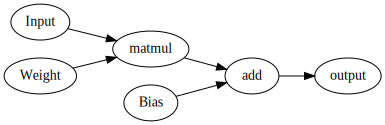

In [80]:
#hide_input
gv('''
Input->matmul->add->output
Weight->matmul
Bias->add
''')

### Backward Propagation:

In this step the gradients of the output wrt to the inputs, weights and bias are calculated.

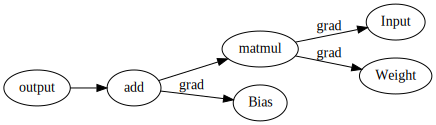

In [81]:
#hide_input
gv('''
output->add->matmul
matmul->Input[label=grad]
matmul->Weight[label=grad]
add->Bias[label=grad]
''')

### Coding up the Linar Layer:

In [213]:
# forward function
def linear_forward(inp, w, b):
    """
    Implement the linear part of a layer's forward propagation.

    Args:
    inp : activations from previous layer (or input data): (size of previous layer, number of examples)
    W : weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b : bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z : the input of the activation function, also called pre-activation parameter 
    cache : a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    z = x @ w + b
    cache = (inp, w, b)
    return z, cache

In [ ]:
# backward function
def linear_backward(grad, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    grad -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of cost wrt to the activation of the previous or the input of the current of layer
    dW -- Gradient of the cost with respect to W
    db -- Gradient of the cost with respect to b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
#     dW = 1/m * np.dot(dZ, cache[0].T)
#     db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    # gradient of cost wrt to the activation of the previous or the input of the current of layer
    dA_prev = grad @ W.T
    dW = 1/m * np.dot(dZ, cache[0].T)
    db = 1/m * np.sum(grad, axis=1, keepdims=True)
    
    return dA_prev, dW, db
    